In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import cv2 as cv
import sklearn
import pickle
from PIL import Image
from scipy import io, ndimage
import audutils

with open('data/train_labels', 'rt') as f:
    labels = f.readlines()
labels = [x.split(',') for x in labels]
labels = {x[1]: int(x[3]) for x in labels}

In [15]:
song, sr = librosa.load('train/000002.ogg', sr=None)
hpss_m = 4
hnodes = [0.25, 0.5, 1, 2, 3, 4]
sraw = song
scale = sr / 22050

sgram = librosa.stft(sraw, n_fft=int(2048 * scale))
msgram = librosa.feature.melspectrogram(S=np.abs(sgram)**2, sr=sr, n_mels=140, fmax=6144)
dbsgram = librosa.amplitude_to_db(np.abs(sgram), ref=np.max)
dbmsgram = librosa.power_to_db(msgram, ref=np.max)
mscc = librosa.feature.mfcc(S=librosa.power_to_db(msgram))
mels = librosa.mel_frequencies(n_mels=140, fmax=6144)

centro = librosa.feature.spectral_centroid(y=sraw, sr=sr, n_fft=int(1024 * scale))
ctime = librosa.times_like(centro)

peaks = librosa.onset.onset_strength(y=sraw, sr=sr)
tgram = librosa.feature.tempogram(onset_envelope=peaks, sr=sr)
fuzziness = librosa.feature.zero_crossing_rate(sraw)
bpm = librosa.beat.tempo(onset_envelope=peaks)
ftf = librosa.tempo_frequencies(len(np.mean(tgram, axis=1)))
ftgram = librosa.interp_harmonics(x=np.mean(tgram, axis=1), freqs=ftf, harmonics=hnodes, axis=0)

heff = librosa.effects.harmonic(sraw, margin=hpss_m)
chrome = librosa.feature.chroma_cqt(y=heff, sr=sr)
fchrome = np.minimum(chrome, librosa.decompose.nn_filter(chrome, aggregate=np.median, metric='cosine'))
chrome_smooth = ndimage.median_filter(fchrome, size=(1, 9))
tonnetz = librosa.feature.tonnetz(y=heff, sr=sr)

print('bpm', bpm)
print('fuzziness', np.sum(fuzziness))
print(audutils.key_finder(chrome, tonnetz))


bpm [151.99908088]
fuzziness 131.61962890625
[(1081.6572, 'f'), (1398.5408, 'c'), (1285.8232, 'g'), (1124.0259, 'd'), (552.52563, 'a_b'), (1081.6572, 'b')]
c_M


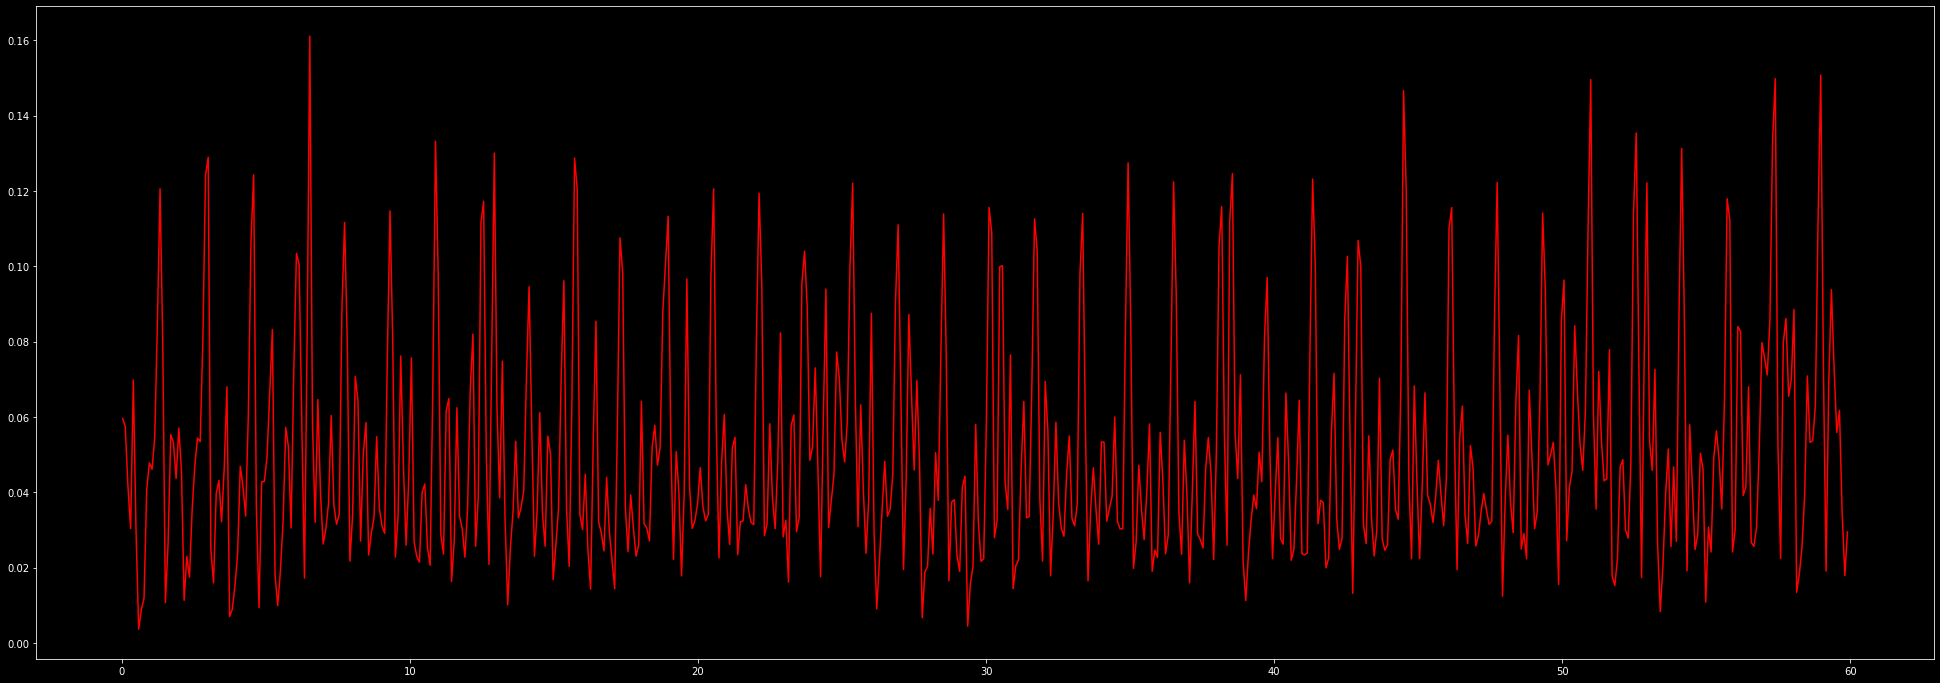

In [25]:
fig = plt.figure(figsize=(34, 12))
ax = plt.axes()
ax.plot(ctime, fuzziness.T, color='r')
ax.plot(ctime, centro.T / 8192, label='Spectral centroid', color='b')
#plt.ylim(0, 6144)
plt.show()

In [19]:
np.max(fuzziness)

0.20654296875

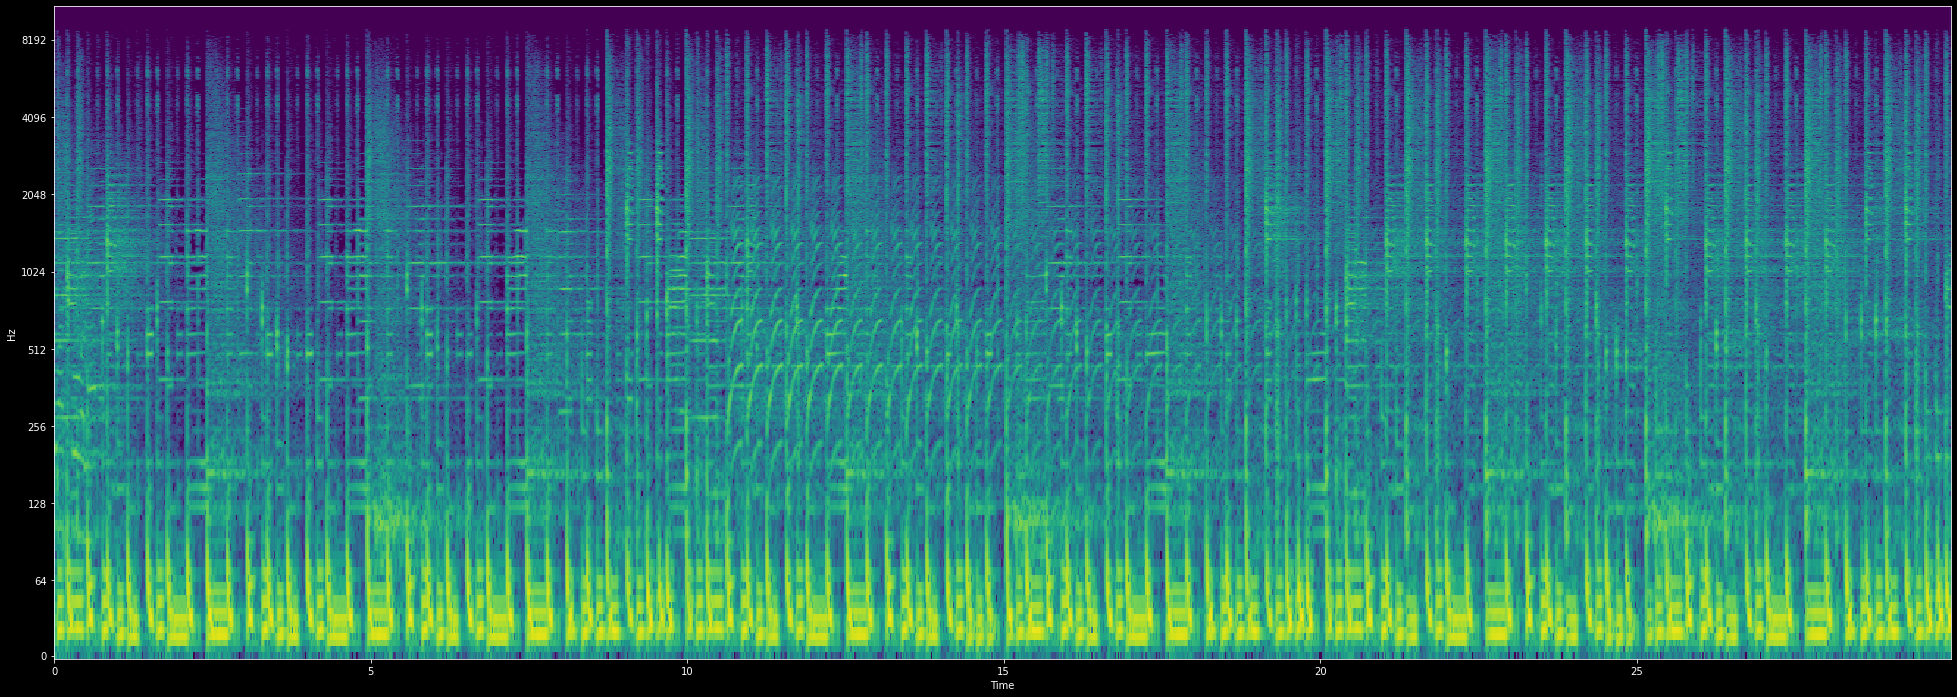

In [24]:
fig = plt.figure(figsize=(34, 12))
ax = plt.axes()
librosa.display.specshow(dbsgram, y_axis='log', x_axis='time', ax=ax, cmap='viridis')
#plt.ylim(0, 6144)
plt.show()

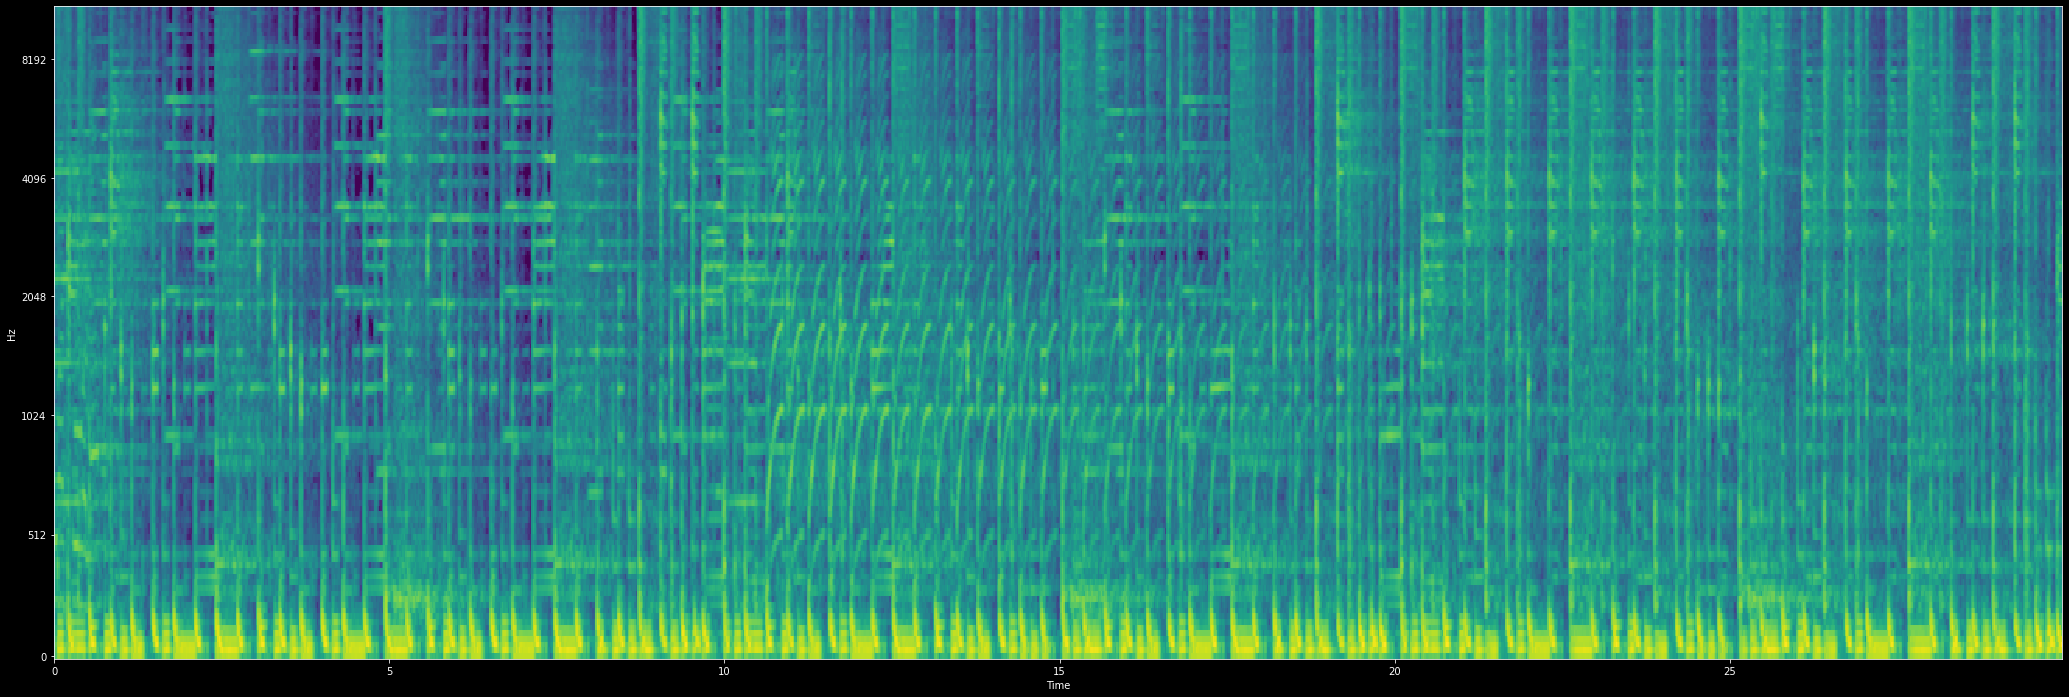

In [4]:
fig = plt.figure(figsize=(36, 12))
ax = plt.axes()

#librosa.display.specshow(test[1], x_axis='time', y_axis='mel', ax=ax)
librosa.display.specshow(dbmsgram, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
#plt.ylim(0, 6144)
plt.show()

In [7]:

selection = np.random.randint(0, dbmsgram.shape[1] - 128)

""" img = np.invert(np.uint8(np.abs(dbmsgram[:, selection:selection+128]) * 2))
display(Image.fromarray(img).resize((500, 500))) """

fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
librosa.display.specshow(dbmsgram[:, selection:selection+128], y_axis='mel', x_axis='time', ax=ax, cmap='viridis')
plt.show()


(160, 1291)

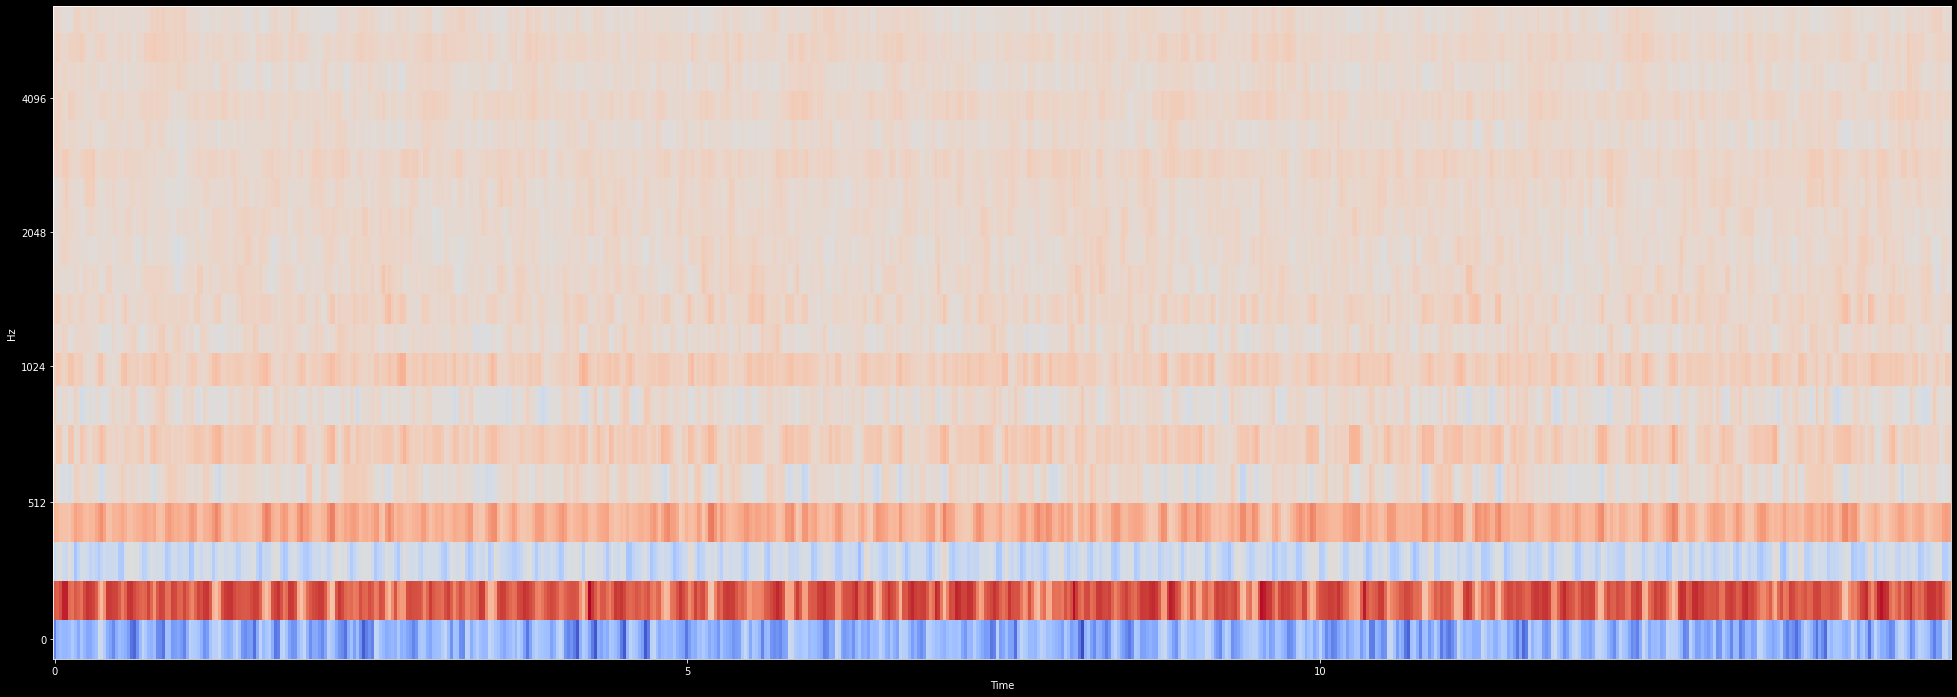

In [50]:
fig = plt.figure(figsize=(34, 12))
ax = plt.axes()
librosa.display.specshow(mscc, x_axis='time', y_axis='mel', fmax=6144, ax=ax)
plt.show()

In [2]:
song, sr = librosa.load('train/000002.ogg', sr=None)
scale = sr / 22050
sgrm = librosa.feature.melspectrogram(y=song, sr=sr)
sgrm = librosa.power_to_db(sgrm, ref=np.max)

In [72]:
targ = 5
print(np.min(item[targ]), np.max(item[targ]))

-8.21 40.56


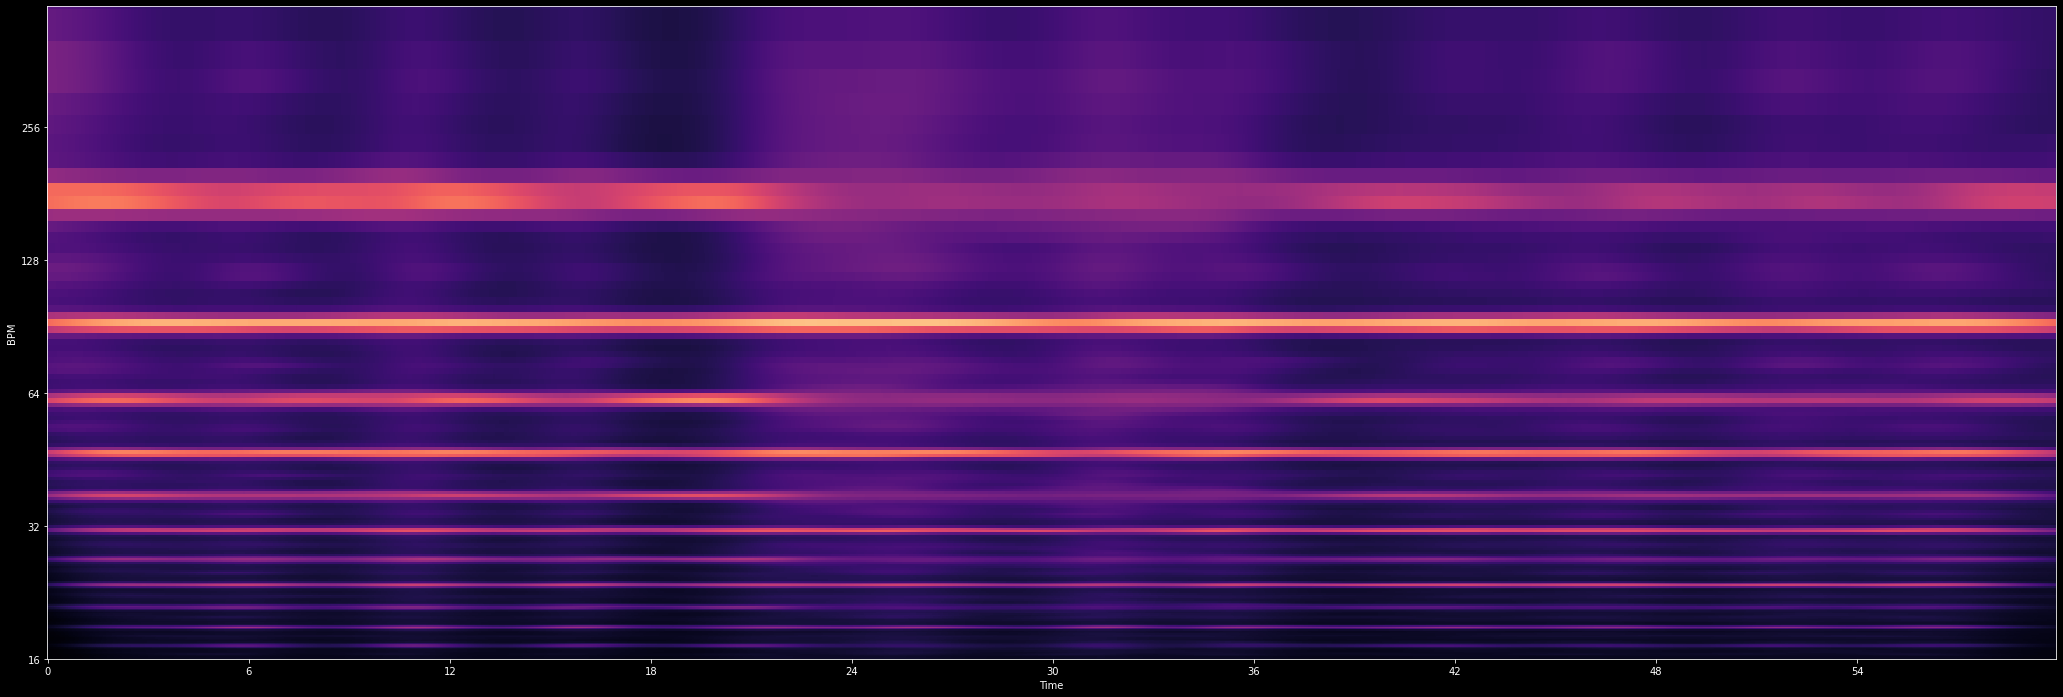

In [6]:
fig = plt.figure(figsize=(36, 12))
ax = plt.axes()
librosa.display.specshow(tgram, x_axis='time', y_axis='tempo',ax=ax)
plt.show()

In [17]:
tgram.shape

(384, 2582)

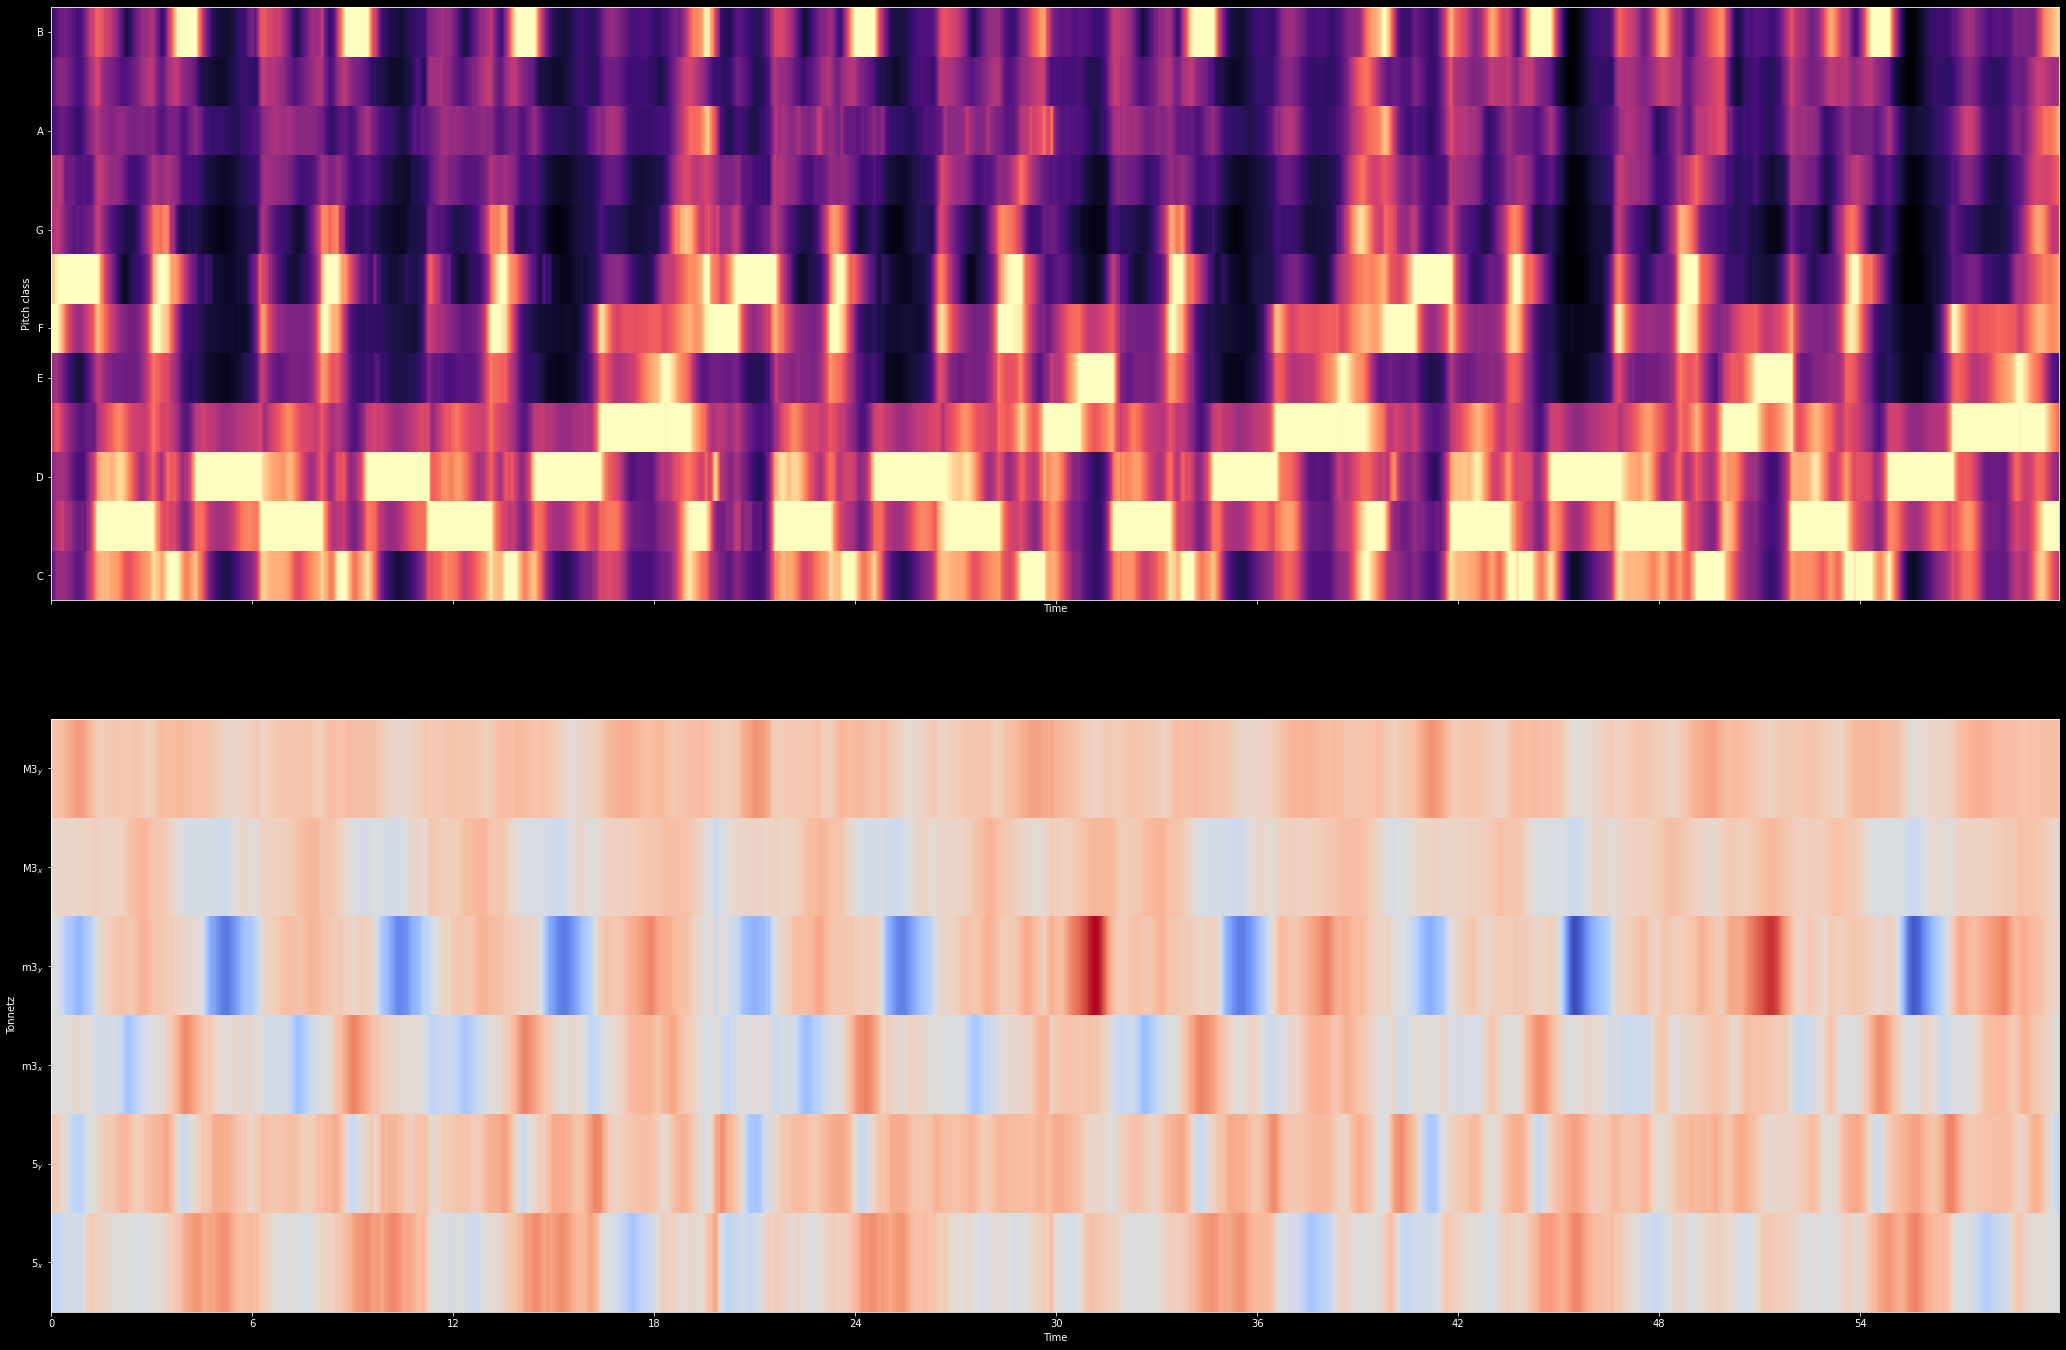

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(36, 24)
librosa.display.specshow(chrome, y_axis='chroma', x_axis='time', ax=ax[0])
librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time', ax=ax[1])
plt.show()

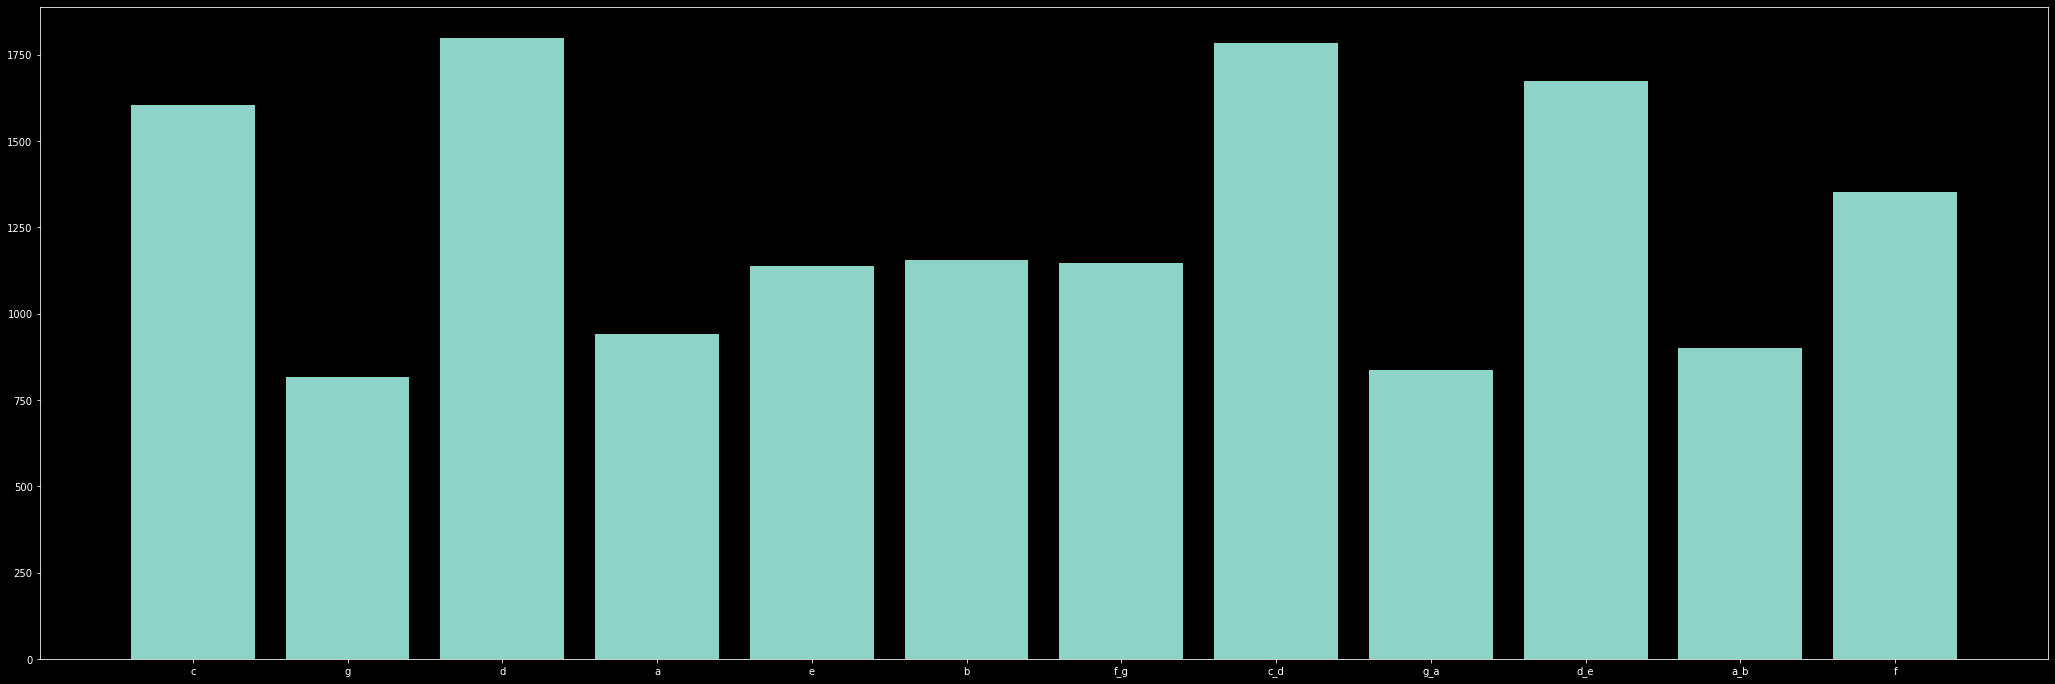

In [9]:
chromefs = np.array([chrome[0], chrome[7], chrome[2], chrome[9], chrome[4], chrome[11], chrome[6], chrome[1], chrome[8], chrome[3], chrome[10], chrome[5]])
fig = plt.figure(figsize=(36, 12))
ax = plt.axes()
plt.bar(range(12), [np.sum(x) for x in chromefs])
plt.xticks(ticks=range(12), labels=audutils.cofs)
plt.show()


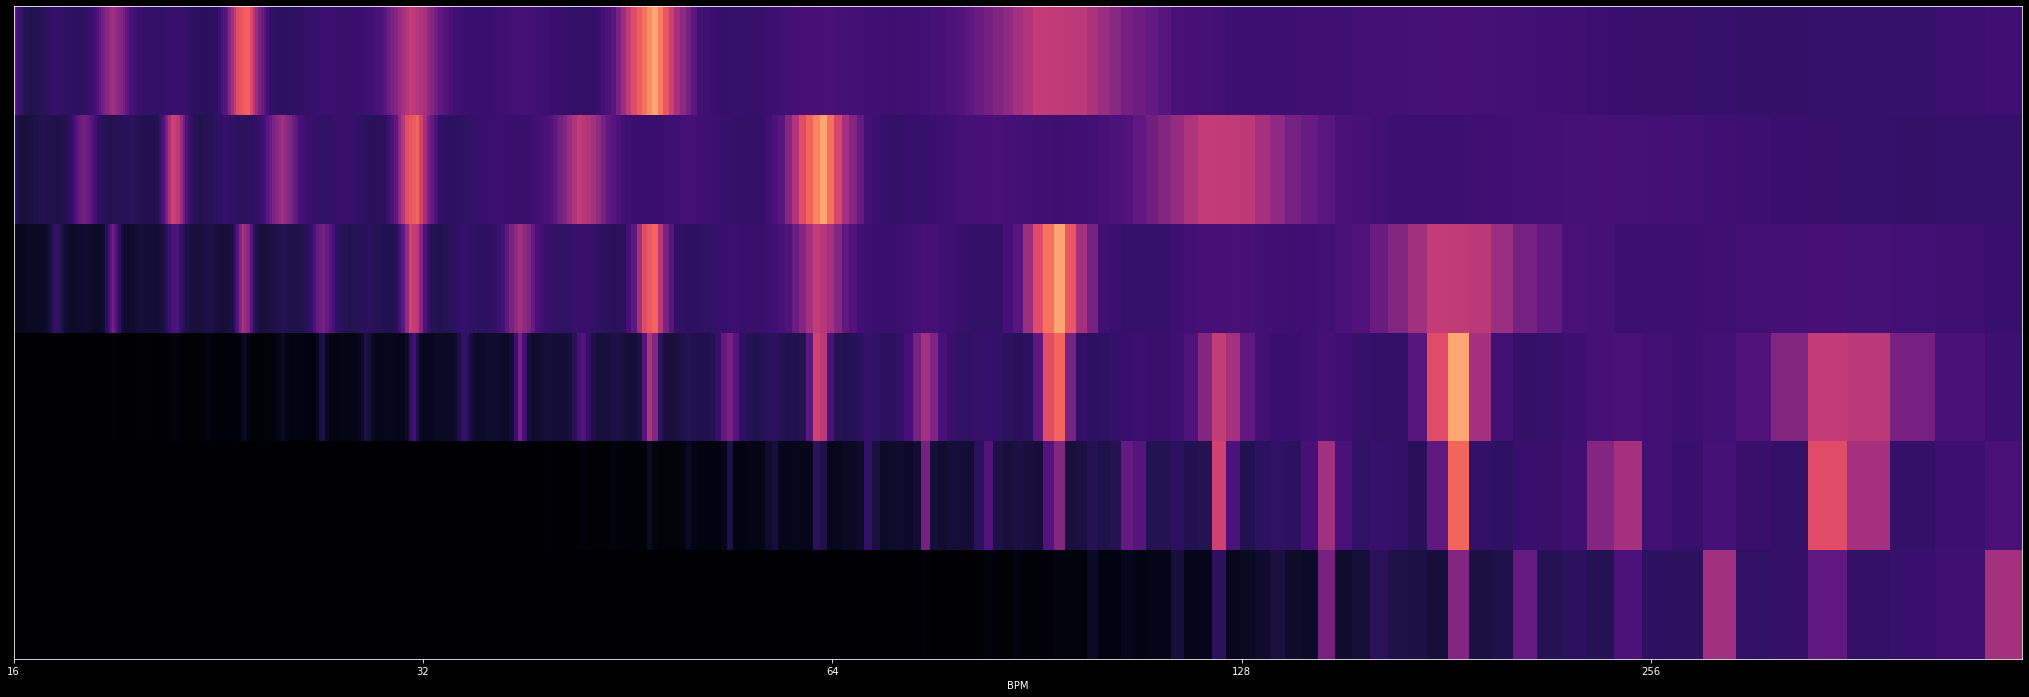

In [10]:
fig = plt.figure(figsize=(36, 12))
ax = plt.axes()
librosa.display.specshow(ftgram, x_axis='tempo', sr=sr, ax=ax)
plt.show()

In [ ]:
spart, sphase = librosa.magphase(sgram)
prfilter = np.minimum(spart, librosa.decompose.nn_filter(spart, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr))))
mask_i = librosa.util.softmask(prfilter, 2 * (spart - prfilter), power=2)
mask_v = librosa.util.softmask(spart - prfilter, 10 * prfilter, power=2)
primaries = mask_v * spart
bgm = mask_i * spart

sfore = librosa.istft(primaries * sphase)
io.wavfile.write('aaa/foretest.wav', 22050, sfore)

fig = plt.figure(figsize=(36, 12))
ax = plt.axes()
librosa.display.specshow(librosa.amplitude_to_db(primaries, ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax)
plt.show()